In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving augmented_data_restaurant_bert.csv to augmented_data_restaurant_bert (1).csv


In [ ]:
# # Load dataset
# restaurant_data = pd.read_csv("/content/augmented_data_restaurant.csv")

# Extract text and labels
X = restaurant_data['text']
y = restaurant_data['aspect_category']

# Tokenization
vocab_size = 6000  # Limit vocabulary size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)

# Convert text to tokenized matrix
X_tokenized = tokenizer.texts_to_matrix(X)  # Convert to numerical representation

# Encode aspect categories
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # One-hot encoding

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y_categorical, test_size=0.2, random_state=1)


In [ ]:
def build_generator(latent_dim, output_dim):
    model = Sequential([
        Dense(256, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(output_dim, activation='tanh')
    ])
    return model


In [ ]:
def build_discriminator(input_dim):
    model = Sequential([
        Dense(512, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model


In [ ]:
latent_dim = 100  # Noise vector size
output_dim = X_train.shape[1]  # Same as input dimension for the classifier

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)

# Make Discriminator non-trainable when training GAN
discriminator.trainable = False

gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
def train_gan(epochs, batch_size=128):
    for epoch in range(epochs):
        # Select real samples
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]

        # Generate fake samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)

        # Create labels
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator (through GAN)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

train_gan(epochs=5000, batch_size=128)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [ ]:
def generate_synthetic_data(num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data

synthetic_samples = generate_synthetic_data(500)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [ ]:
X_combined = np.vstack((X_train, synthetic_samples))
y_combined = np.vstack((y_train, y_train[:synthetic_samples.shape[0]]))  # Duplicate labels

X_test_final = X_test
y_test_final = y_test


In [ ]:
classifier = Sequential([
    Dense(512, activation='relu', input_shape=(output_dim,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

classifier.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])


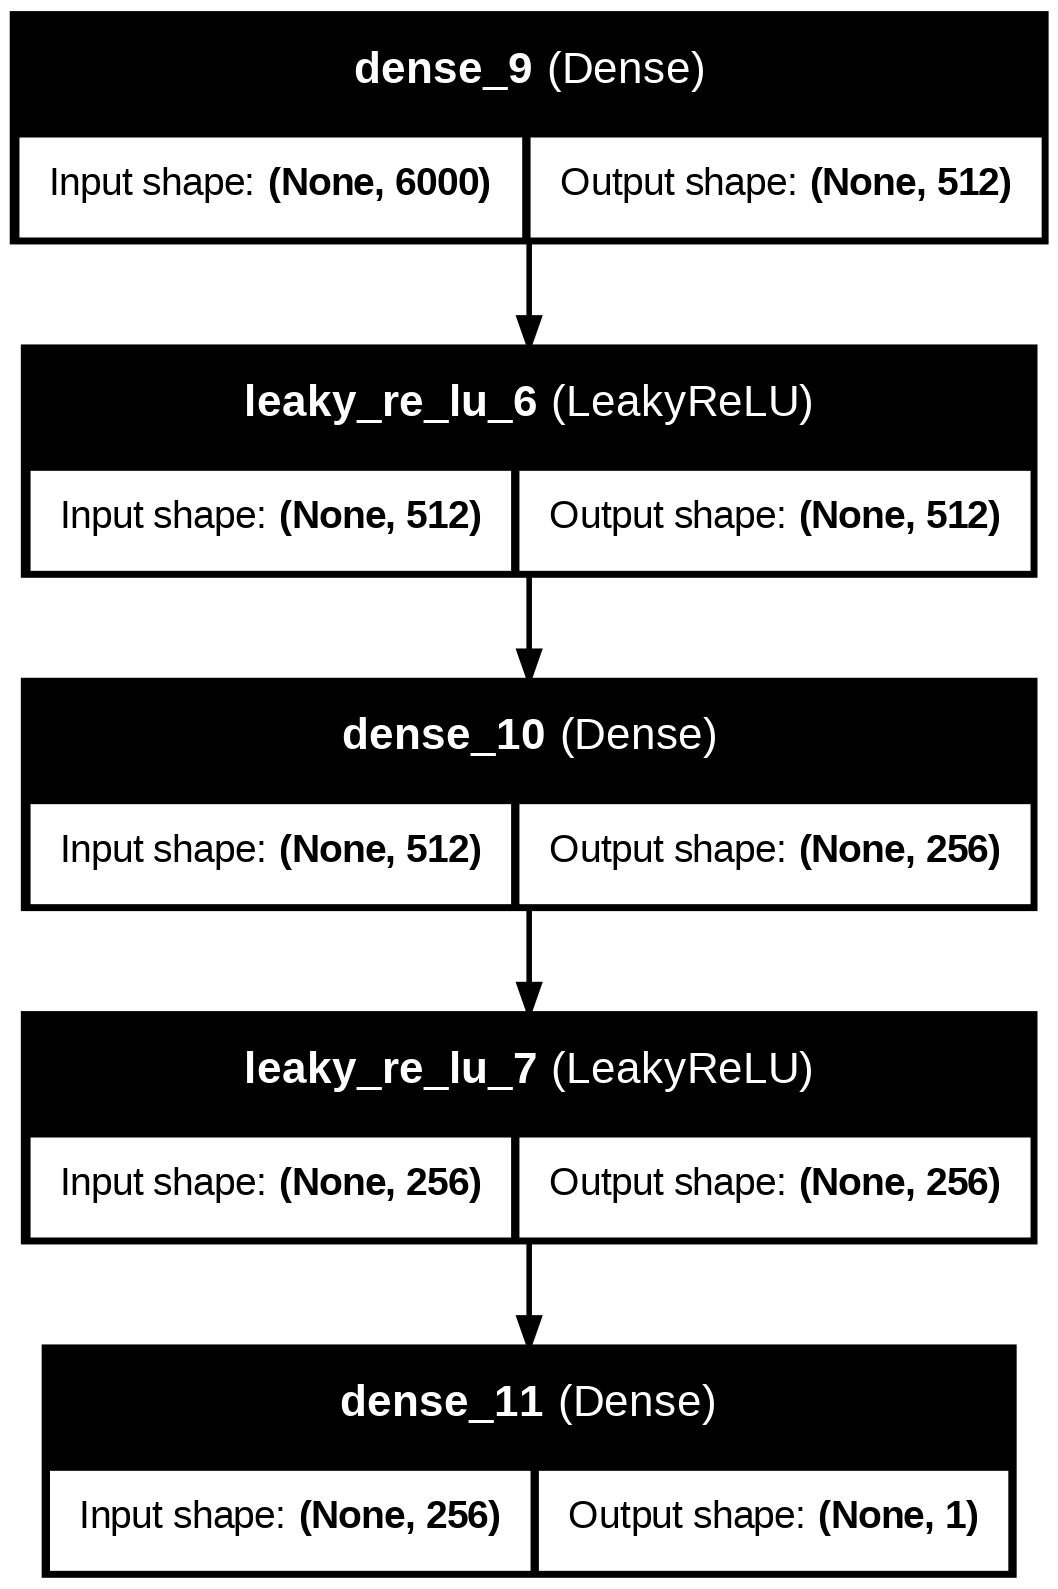

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the classifier model structure
plot_model(classifier, to_file="classifier_model.png", show_shapes=True, show_layer_names=True)

# Plot the GAN structure (Generator & Discriminator)
plot_model(generator, to_file="generator_model.png", show_shapes=True, show_layer_names=True)
plot_model(discriminator, to_file="discriminator_model.png", show_shapes=True, show_layer_names=True)


In [ ]:
history = classifier.fit(X_combined, y_combined, validation_data=(X_test_final, y_test_final), epochs=25, verbose=1)


Epoch 1/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.3704 - loss: 1.6904 - val_accuracy: 0.5714 - val_loss: 1.2076
Epoch 2/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6257 - loss: 1.3369 - val_accuracy: 0.7085 - val_loss: 0.8499
Epoch 3/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.7427 - loss: 0.9351 - val_accuracy: 0.8161 - val_loss: 0.6045
Epoch 4/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8331 - loss: 0.6195 - val_accuracy: 0.8424 - val_loss: 0.4840
Epoch 5/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.8743 - loss: 0.4350 - val_accuracy: 0.8596 - val_loss: 0.4046
Epoch 6/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9089 - loss: 0.3089 - val_accuracy: 0.8834 - val_loss: 0.3692
Epoch 7/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9248 - loss: 0.2656 - val_accuracy: 0.8916 - val_loss: 0.3424
Epoch 8/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9423 - loss: 0.2087 - val_a

In [ ]:
predictions = classifier.predict(X_test_final)
predicted_labels = np.argmax(predictions, axis=1)
predicted_cat = label_encoder.inverse_transform(predicted_labels)

from sklearn.metrics import classification_report
print(classification_report(label_encoder.inverse_transform(np.argmax(y_test_final, axis=1)), predicted_cat))


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
                         precision    recall  f1-score   support

               ambience       0.93      0.84      0.88       164
anecdotes/miscellaneous       0.89      0.95      0.92       400
                   food       0.94      0.90      0.92       355
                  price       0.94      0.88      0.91       113
                service       0.88      0.90      0.89       186

               accuracy                           0.91      1218
              macro avg       0.92      0.90      0.91      1218
           weighted avg       0.91      0.91      0.91      1218



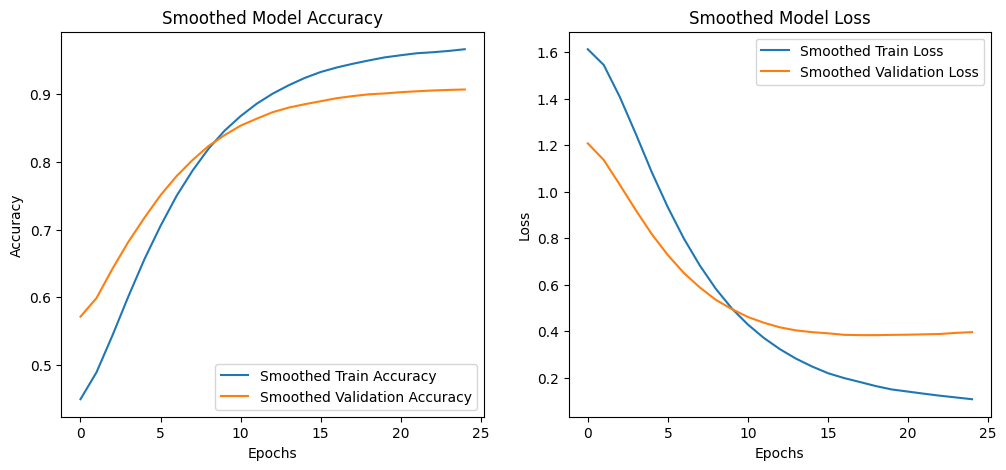

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    """Smooths the curve using exponential moving average."""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Extract training history
train_acc = smooth_curve(history.history['accuracy'])
val_acc = smooth_curve(history.history['val_accuracy'])
train_loss = smooth_curve(history.history['loss'])
val_loss = smooth_curve(history.history['val_loss'])

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Smoothed Train Accuracy')
plt.plot(val_acc, label='Smoothed Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Smoothed Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Smoothed Train Loss')
plt.plot(val_loss, label='Smoothed Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Smoothed Model Loss')

plt.show()


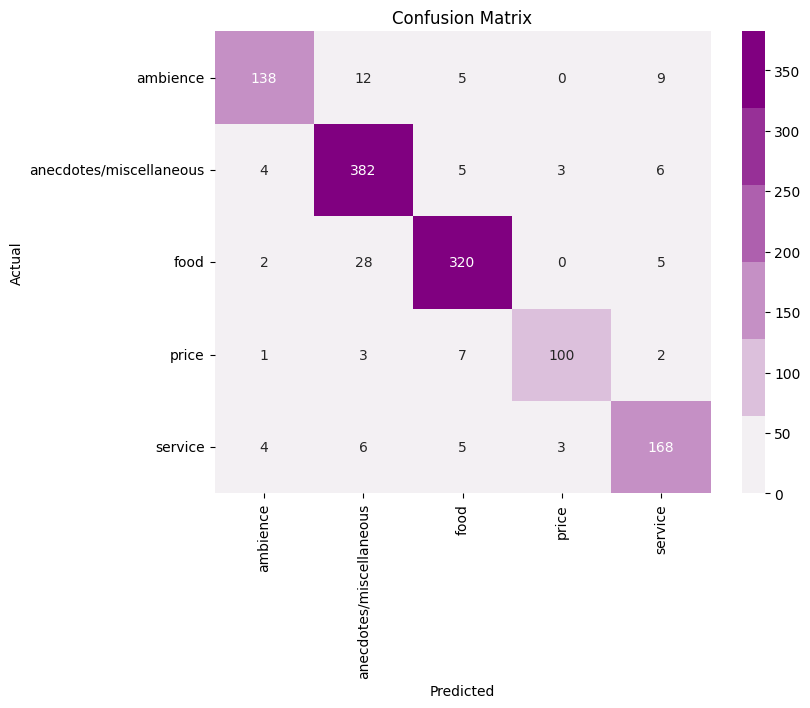

In [ ]:
# plot_confusion_matrix(y_test,  predicted_cat, catagories)
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(y_test_final, axis=1)), predicted_cat)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
# Change 'purple' to a valid colormap name like 'Purples' or 'viridis'
sns.heatmap(cm, annot=True, fmt="d",cmap=sns.light_palette("purple"),  xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()